In [1]:
import re
import pandas as pd
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


# preprocessing

In [4]:
data.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
data = data[~data['Review Text'].isnull()]
data = data[~data['Class Name'].isnull()]
data = data[~data['Title'].isnull()]

In [6]:
data = data.drop(['Clothing ID', 'Age', 'Positive Feedback Count', 'Division Name', 'Department Name'], axis=1)

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text) 
    text = text.lower() 
    tokens = text.split()  
    tokens = [word for word in tokens if word not in stopwords.words('english')]  
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  
    return ' '.join(tokens)

In [8]:
data['Text'] = data['Title'] + ' ' + data['Review Text']

data['Cleaned_Text'] = data['Text'].apply(preprocess_text)

data['Text_lenght'] = data['Text'].apply(len)

data['Rating'] = pd.cut(data['Rating'], bins=2, labels=[0, 1], duplicates='drop')

In [9]:
X = data['Cleaned_Text']
y = data['Rating']

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X)

In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Visualization

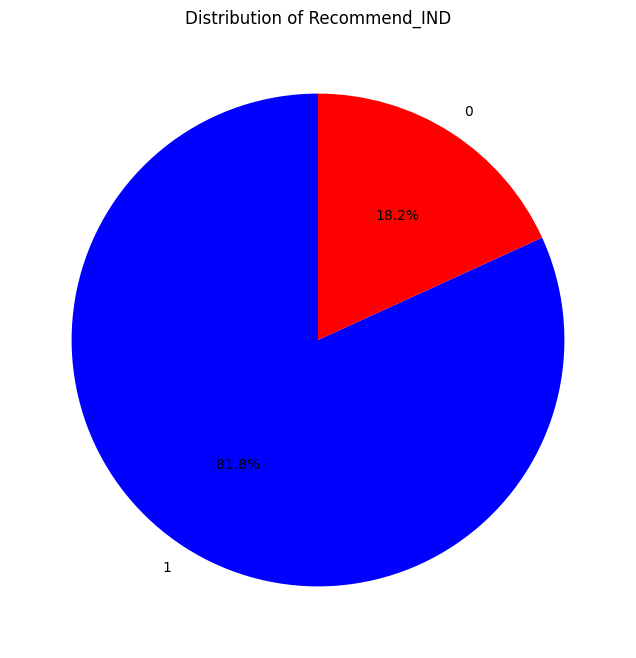

In [11]:
target_counts = data['Recommended IND'].value_counts()


plt.figure(figsize=(8, 8)) 
plt.pie(
    target_counts, 
    labels=target_counts.index, 
    autopct='%1.1f%%',
    colors=['blue', 'red'], 
    startangle=90
)
plt.title("Distribution of Recommend_IND")
plt.show()


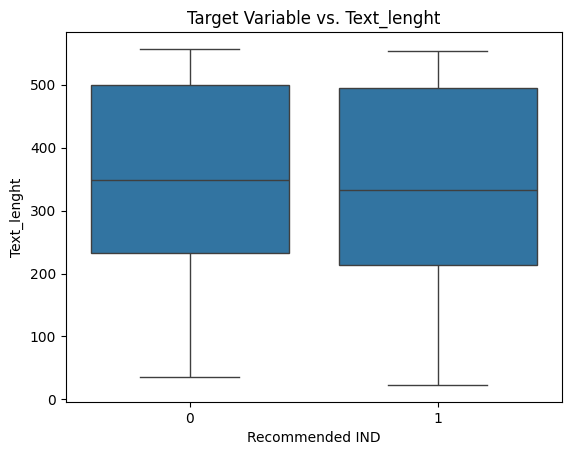

In [12]:
sns.boxplot(x='Recommended IND', y='Text_lenght', data=data)
plt.title("Target Variable vs. Text_lenght")
plt.xlabel("Recommended IND")
plt.ylabel("Text_lenght")
plt.show()


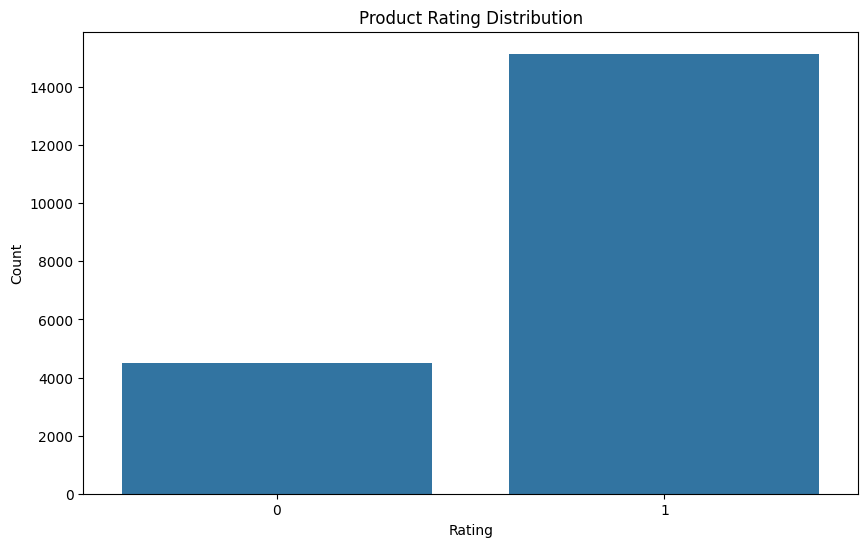

In [13]:

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Rating')
plt.title("Product Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


C:\Users\yasse\AppData\Local\Temp\ipykernel_17940\1086346046.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_data = data.groupby(['Rating', 'Recommended IND']).size().reset_index(name='Count')
C:\Users\yasse\AppData\Local\Temp\ipykernel_17940\1086346046.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_data['Percentage'] = percentage_data.groupby('Rating')['Count'].transform(lambda x: (x / x.sum()) * 100)


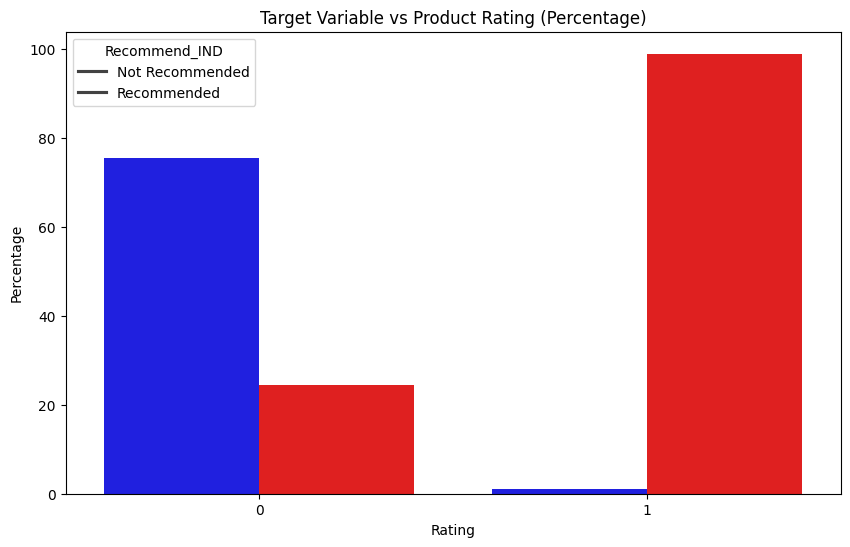

In [14]:
percentage_data = data.groupby(['Rating', 'Recommended IND']).size().reset_index(name='Count')
percentage_data['Percentage'] = percentage_data.groupby('Rating')['Count'].transform(lambda x: (x / x.sum()) * 100)

plt.figure(figsize=(10, 6))
sns.barplot(data=percentage_data, x='Rating', y='Percentage', hue='Recommended IND', palette=['blue', 'red'])
plt.title("Target Variable vs Product Rating (Percentage)")
plt.xlabel("Rating")
plt.ylabel("Percentage")
plt.legend(title="Recommend_IND", labels=["Not Recommended", "Recommended"])
plt.show()



In [15]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

data['polarity'] = data['Text'].apply(get_polarity)

def get_sentiment(polarity):
    return 'positive' if polarity > 0 else 'negative'

data['sentiment'] = data['polarity'].apply(get_sentiment)


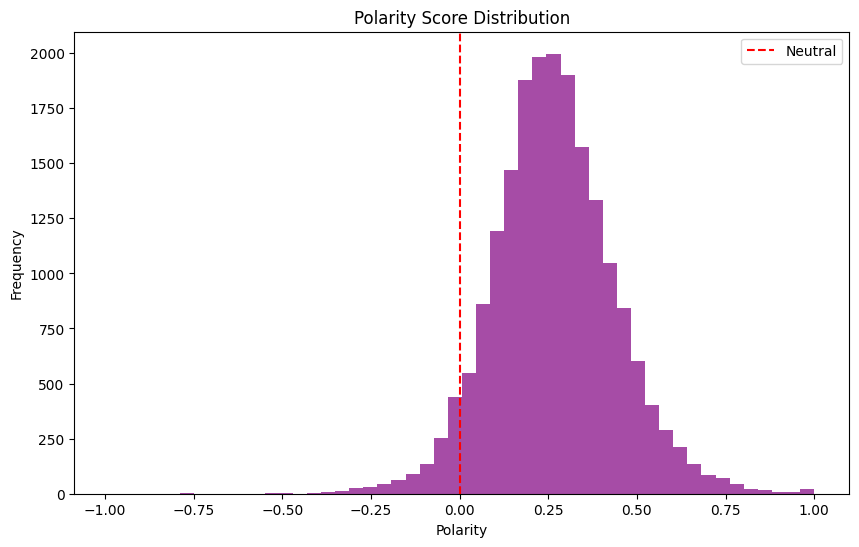

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(data['polarity'], bins=50, color='purple', alpha=0.7)
plt.title("Polarity Score Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Neutral')
plt.legend()
plt.show()

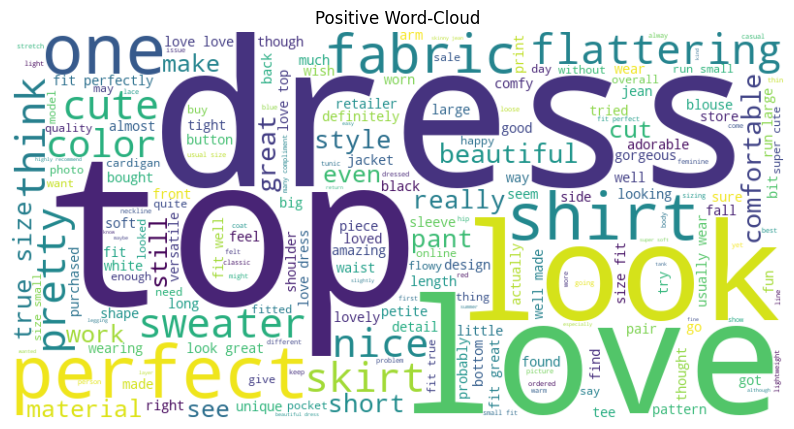

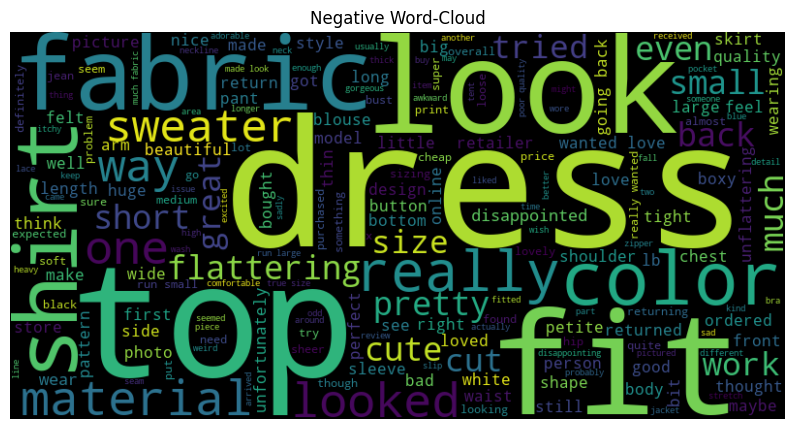

In [17]:
positive_reviews = " ".join(data[data['Recommended IND'] == 1]['Cleaned_Text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Word-Cloud")
plt.show()

negative_reviews = " ".join(data[data['Recommended IND'] == 0]['Cleaned_Text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Word-Cloud")
plt.show()


# Ensemble Model

In [18]:
catboost_model = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, verbose=0)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

meta_model = LogisticRegression()

stacking_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('random_forest', random_forest_model)
    ],
    final_estimator=meta_model
)

stacking_ensemble.fit(X_train, y_train)

y_pred = stacking_ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9414094735104803
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      3039
           1       0.94      0.94      0.94      3020

    accuracy                           0.94      6059
   macro avg       0.94      0.94      0.94      6059
weighted avg       0.94      0.94      0.94      6059

